In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

In [2]:
date = "Oct-25-2022" #"Sep-25-2022" #"Aug-21-2022" #Oct-19-2022"
param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/sim_study/" + date
#param_folder = "/Volumes/One Touch/sublinear-HMM-inference/sim_study/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/sim_study/" + date

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

methods = ["control","BFGS","GD","CG","SAGA","SVRG"]

tol = 1e-2

In [3]:
def load_optims(T,K,d,data_set):
    
    optims = {}
    times_to_converge = {}
    epochs_to_converge = {}
    lls = {}
    
    for method in methods:
        for partial_E in partial_Es:
            if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
                pass
            else:

                # get best ll
                best_ll = -np.infty
                best_fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,0,data_set)

                # initialize lls
                lls[(method,partial_E)] = []

                # initialize epochs
                epochs_to_converge[(method,partial_E)] = []

                # initialize times
                times_to_converge[(method,partial_E)] = []

                for rand_seed in range(5):

                    fname = param_folder + "/T-%d_K-%d-%d_d-%d_%s_%.1f_%03d_%03d" % (T,K[0],K[1],d,method,partial_E,rand_seed,data_set)

                    try:
                        with open(fname, 'rb') as f:
                            optim = pickle.load(f)
                        #print("loaded file %s" % fname)
                    except:
                        #print("file %s does not exist" % fname)
                        continue

                    # check for some issue (likely nan in theta)
                    if len(optim.time_trace) == 0:
                        #print("file %s didn't optimize." % fname)
                        continue


                    # get convergence ind
                    converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                       default=len(optim.grad_norm_trace)-1)

                    epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                    times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                    lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])

                    if optim.log_like_trace[-1] > best_ll:    
                        optims[(method,partial_E)] = optim
                        best_fname = fname
                        best_ll = optim.log_like_trace[-1]

                #print(best_fname)
                
    return optims,lls,epochs_to_converge,times_to_converge

# Plot boxplots

1000 [3, 1] 3
1000 [3, 1] 6
1000 [6, 1] 3
1000 [6, 1] 6


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_8246/779341738.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


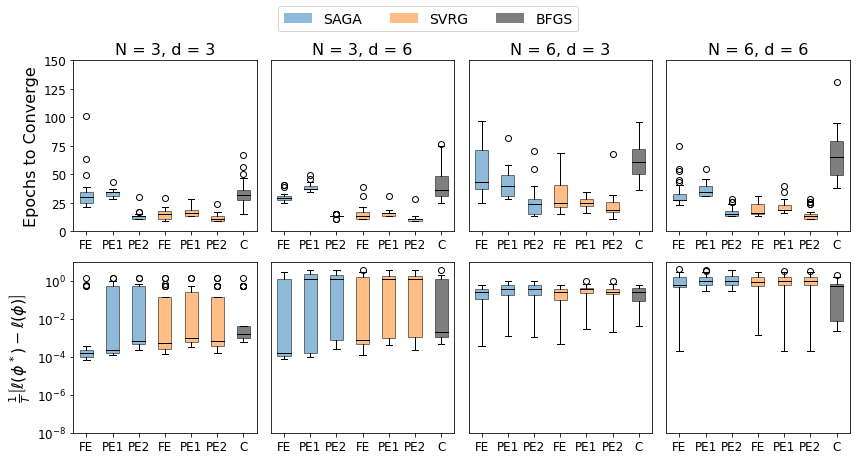

In [14]:
fig1, axs1 = plt.subplots(2,4,figsize = (12,6))
#fig2, axs2 = plt.subplots(2,4,figsize = (10,6))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

for T,K,d in product([1000],[[3,1],[6,1]],[3,6]):
    
    print(T,K,d)
    
    yind = 0
    xind = int(d == 6) + 2*int(K[0] == 6)

    ll_star = []
    theta_star = []
    eta_star = []
    eta0_star = []
    
    epochs_to_converge = []
    times_to_converge = []
    lls = []
    
    for dataset in range(5):
        
        optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)
        
        ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
        theta_star.append(optims[("SAGA",0.0)].theta)
        eta_star.append(optims[("SAGA",0.0)].eta)
        eta0_star.append(optims[("SAGA",0.0)].eta0)
        
        lls.append(lls0)
        epochs_to_converge.append(epochs_to_converge0)
        times_to_converge.append(times_to_converge0)
        
        for key in optims:

            if key[0] == 'control':
                continue

            if ll_star[dataset] < optims[key].log_like_trace[-1]:

                update_ll = True
                for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                    if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                        update_ll = False
                        break

                if update_ll:
                    ll_star[dataset] = optims[key].log_like_trace[-1]
                    theta_star[dataset] = optims[key].theta
                    eta_star[dataset] = optims[key].eta
                    eta0_star[dataset] = optims[key].eta0

    
    keys = [("SAGA",0.0),
            ("SAGA",0.5),
            ("SAGA",1.0),
            ("SVRG",0.0),
            ("SVRG",0.5),
            ("SVRG",1.0),
            ("BFGS",0.0)]
    
    labs = ["FE","PE1","PE2","FE","PE1","PE2","C"]
    
    data_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(epochs_to_converge[dataset][key])
        data_to_plot.append(key_data)

    box = axs1[yind,xind].boxplot(data_to_plot, 
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  patch_artist=True,
                                  labels=labs)

    linestyles = {("BFGS",0.0):("black","-"),
                  ("CG",0.0)  :("black","--"),
                  ("GD",0.0)  :("black",":"),
                  ("SAGA",0.0):(cmap(0),"-"),
                  ("SAGA",0.5):(cmap(0),"--"),
                  ("SAGA",1.0):(cmap(0),":"),
                  ("SVRG",0.0):(cmap(1),"-"),
                  ("SVRG",0.5):(cmap(1),"--"),
                  ("SVRG",1.0):(cmap(1),":")}

    for patch, key in zip(box['boxes'], keys):
        patch.set_facecolor(linestyles[key][0])
        patch.set_alpha(0.5)

    if xind == 0:
        axs1[yind,xind].set_ylabel("Epochs to Converge",fontsize=16)
    else:
        axs1[yind,xind].set_yticks([])
        
    if T == 1000:
        axs1[yind,xind].set_ylim([0,150])
    else:
        axs1[yind,xind].set_ylim([0,80])
    
    # set title and font sizes
    axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d), fontsize=16)
    axs1[yind,xind].tick_params(axis='both', which='major', labelsize=12)
    axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=12)

    #######
    
    yind = 1

    data_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(ll_star[dataset] - lls[dataset][key])
        data_to_plot.append(key_data)
        
    box = axs1[yind,xind].boxplot(data_to_plot, 
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  patch_artist=True,
                                  labels=labs)

    linestyles = {("BFGS",0.0):("black","-"),
                  ("CG",0.0)  :("black","--"),
                  ("GD",0.0)  :("black",":"),
                  ("SAGA",0.0):(cmap(0),"-"),
                  ("SAGA",0.5):(cmap(0),"--"),
                  ("SAGA",1.0):(cmap(0),":"),
                  ("SVRG",0.0):(cmap(1),"-"),
                  ("SVRG",0.5):(cmap(1),"--"),
                  ("SVRG",1.0):(cmap(1),":")}

    for patch, key in zip(box['boxes'], keys):
        patch.set_facecolor(linestyles[key][0])
        patch.set_alpha(0.5)

    axs1[yind,xind].set_yscale("log")
    axs1[yind,xind].set_ylim([1e-8,1e1])
        
    if xind == 0:
        axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi^*) - \ell(\phi)\right]$",fontsize=16)
    else:
        axs1[yind,xind].set_yticks([])
        
    axs1[yind,xind].tick_params(axis='both', which='major', labelsize=12)
    axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=12)
        
    #axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d))

legend_elements = [Patch(facecolor=cmap(0), alpha=0.5, label='SAGA'),
                   Patch(facecolor=cmap(1), alpha=0.5, label='SVRG'),
                   Patch(facecolor='black', alpha=0.5, label='BFGS')]

fig1.legend(handles=legend_elements,
            loc='upper center',
            fontsize=14,
            bbox_to_anchor=(0.5, 1.075),
            ncol=4)
    
fig1.tight_layout()
fig1.show()

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

fig1.savefig(plot_folder + '/boxplots_sim_T_%d.png'%T,
             dpi=500,
             bbox_inches='tight')

# Plot scatterplots

1000 [3, 1] 3
1000 [3, 1] 6
1000 [6, 1] 3
1000 [6, 1] 6


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_8246/3014861021.py:141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


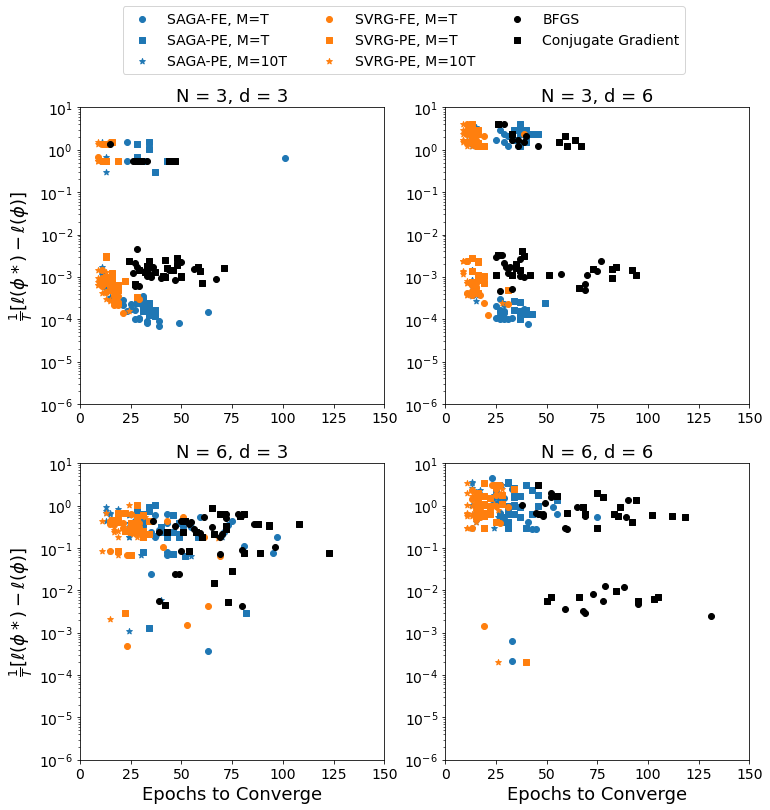

In [15]:
fig1, axs1 = plt.subplots(2,2,figsize=(12,12))

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]
T = 1000

for K,d in product([[3,1],[6,1]],[3,6]):
    
    print(T,K,d)
    
    yind = int(K[0] == 6)#int(T == 100000)
    xind = int(d == 6) #+ 2*int(K[0] == 6)

    ll_star = []
    theta_star = []
    eta_star = []
    eta0_star = []
    
    epochs_to_converge = []
    times_to_converge = []
    lls = []
    
    for dataset in range(5):
        
        optims,lls0,epochs_to_converge0,times_to_converge0 = load_optims(T,K,d,dataset)
        
        ll_star.append(optims[("SAGA",0.0)].log_like_trace[-1])
        theta_star.append(optims[("SAGA",0.0)].theta)
        eta_star.append(optims[("SAGA",0.0)].eta)
        eta0_star.append(optims[("SAGA",0.0)].eta0)
        
        lls.append(lls0)
        epochs_to_converge.append(epochs_to_converge0)
        times_to_converge.append(times_to_converge0)
        
        for key in optims:

            if key[0] == 'control':
                continue

            if ll_star[dataset] < optims[key].log_like_trace[-1]:

                update_ll = True
                for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                    if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                        update_ll = False
                        break

                if update_ll:
                    ll_star[dataset] = optims[key].log_like_trace[-1]
                    theta_star[dataset] = optims[key].theta
                    eta_star[dataset] = optims[key].eta
                    eta0_star[dataset] = optims[key].eta0

    
    keys = [("SAGA",0.0),
            ("SAGA",0.5),
            ("SAGA",1.0),
            ("SVRG",0.0),
            ("SVRG",0.5),
            ("SVRG",1.0),
            ("BFGS",0.0),
            ("CG",0.0)]
    
    # define linestyles
    linestyles = {("BFGS",0.0):("black","o"),
                  ("CG",0.0)  :("black","s"),
                  ("GD",0.0)  :("black","*"),
                  ("SAGA",0.0):(cmap(0),"o"),
                  ("SAGA",0.5):(cmap(0),"s"),
                  ("SAGA",1.0):(cmap(0),"*"),
                  ("SVRG",0.0):(cmap(1),"o"),
                  ("SVRG",0.5):(cmap(1),"s"),
                  ("SVRG",1.0):(cmap(1),"*")}
    
    # get data
    epochs_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(epochs_to_converge[dataset][key])
        epochs_to_plot.append(key_data)
        
    lls_to_plot = []
    for key in keys:
        key_data = []
        for dataset in range(5):
            key_data.extend(ll_star[dataset] - lls[dataset][key])
        lls_to_plot.append(key_data)

    # plot data
    for key,epoch_data,ll_data in zip(keys,epochs_to_plot,lls_to_plot):
        axs1[yind,xind].scatter(epoch_data,ll_data,
                                color = linestyles[key][0],
                                marker = linestyles[key][1])
        
    # adjust axes
    axs1[yind,xind].set_yscale('log')
    if xind == 0:
        axs1[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi*) - \ell(\phi)\right]$",
                                   fontsize=18)
        
    if yind == 1:
        axs1[yind,xind].set_xlabel("Epochs to Converge",fontsize=18)
        
    axs1[yind,xind].set_title("N = %d, d = %d" % (K[0],d), fontsize=18)
    
    if T == 1000:
        axs1[yind,xind].set_xlim([0,150])
    else:
        axs1[yind,xind].set_xlim([0,80])
        
    axs1[yind,xind].set_ylim([1e-6,1e1])

    axs1[yind,xind].tick_params(axis='both', which='major', labelsize=14)
    axs1[yind,xind].tick_params(axis='both', which='minor', labelsize=14)

legend_elem = {("BFGS",0.0): "BFGS",
               ("CG",0.0)  : "Conjugate Gradient",
               ("GD",0.0)  : "GD",
               ("SVRG",0.0): "SVRG-FE, M=T",
               ("SVRG",0.5): "SVRG-PE, M=T",
               ("SVRG",1.0): "SVRG-PE, M=10T",
               ("SAGA",0.0): "SAGA-FE, M=T",
               ("SAGA",0.5): "SAGA-PE, M=T",
               ("SAGA",1.0): "SAGA-PE, M=10T"}
# make legend
fig1.legend([legend_elem[key] for key in keys],
            loc='upper center', 
            fontsize=14,
            bbox_to_anchor=(0.5, 1.005),
            ncol=3)

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)
    
fig1.savefig(plot_folder + '/scatter_sim_T_%d.png'%T,
             dpi=500,
             bbox_inches='tight')

fig1.show()

# Plot Results

In [6]:
T = 1000
K = [3,1]
d = 6
dataset = 1

cmap = cm.get_cmap('tab10')
partial_Es = [0,0.5,1]

In [7]:
def find_perm(optim,eta_star,theta_star):
    
    # get the coarse-scale permutation of states
    cost_matrix = np.zeros((optim.K[0],optim.K[0]))
    
    # get the coarse-scale permutation
    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta)[0])
    Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1])

    # get the trace of each fine-scale ptm
    for k0_star in range(optim.K[0]):
        square_dists = np.zeros(optim.K[0])
        for k0_optm in range(optim.K[0]):
            square_dists[k0_optm] += (Gamma_coarse_star[k0_star,k0_star] - \
                                      Gamma_coarse_optm[k0_optm,k0_optm])**2 
            square_dists[k0_optm] += (np.trace(Gamma_fine_star[k0_star]) - \
                                      np.trace(Gamma_fine_optm[k0_optm]))**2 

        cost_matrix[k0_star] = square_dists

    star_states_coarse, optim_states_coarse = linear_sum_assignment(cost_matrix)

    # get the fine-scale permutations
    star_states_fine = [None for _ in range(optim.K[0])]
    optim_states_fine = [None for _ in range(optim.K[0])]

    for k0_star in range(optim.K[0]):
        k0_optm = optim_states_coarse[k0_star]

        # get the fine-scale permutation of states
        cost_matrix = np.zeros((optim.K[1],optim.K[1]))

        # get the fine-scale permutation
        Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1][k0_star])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1][k0_optm])

        for k1_star in range(optim.K[1]):
            square_dists = np.zeros(optim.K[1])
            for k1_optm in range(optim.K[1]):
                for feature in optim.features:
                    square_dists[k1_optm] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                              optim.theta[k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[k1_optm] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                              np.exp(optim.theta[k0_optm][feature]['log_sig'][k1_optm]))**2 
                square_dists[k1_optm] += (Gamma_fine_star[k1_star,k1_star] - \
                                          Gamma_fine_optm[k1_optm,k1_optm])**2 

            cost_matrix[k1_star] = square_dists

        star_states_fine[k0_star], optim_states_fine[k0_optm] = linear_sum_assignment(cost_matrix)

    return optim_states_coarse,optim_states_fine

In [8]:
def find_distances(optim,theta_star,eta_star,eta0_star):

    # get permutation
    optim_states_coarse,optim_states_fine = find_perm(optim,eta_star,theta_star)
    
    # now get distances
    square_dists = np.zeros(len(optim.epoch_trace))

    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    delta_coarse_star = np.exp(eta0_2_log_delta(eta0_star)[0])
    delta_fine_star = np.exp(eta0_2_log_delta(eta0_star)[1])

    for i in range(len(optim.epoch_trace)):

        # add theta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]
            for k1_star in range(optim.K[1]):
                k1_optm = optim_states_fine[k0_optm][k1_star]
                for feature in optim.features:
                    square_dists[i] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                        optim.theta_trace[i][k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[i] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                        np.exp(optim.theta_trace[i][k0_optm][feature]['log_sig'][k1_optm]))**2 

        
        # get Gamma and delta
        Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[0])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[1])

        delta_coarse_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[0])
        delta_fine_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[1])

        # add coarse Gamma and delta
        for i_star in range(optim.K[0]):
            i_optm = optim_states_coarse[i_star]

            for j_star in range(optim.K[0]):
                j_optm = optim_states_coarse[j_star]

                square_dists[i] += (Gamma_coarse_star[i_star,j_star] - \
                                    Gamma_coarse_optm[i_optm,j_optm])**2

            # BUG IN CODE NEED TO FIX :(
            #square_dists[i] += (delta_coarse_star[i_star] - \
            #                    delta_coarse_optm[i_optm])**2
            

        # add fine Gamma and delta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]

            for i_star in range(optim.K[1]):
                i_optm = optim_states_fine[k0_optm][i_star]

                for j_star in range(optim.K[1]):
                    j_optm = optim_states_fine[k0_optm][j_star]

                    square_dists[i] += (Gamma_fine_star[k0_star][i_star,j_star] - \
                                        Gamma_fine_optm[k0_optm][i_optm,j_optm])**2

                # BUG IN CODE NEED TO FIX :(
                #square_dists[i] += (delta_fine_star[k0_star][i_star] - \
                #delta_fine_optm[k0_optm][i_optm])**2
                
    return square_dists

In [9]:
def plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        
        if method == "control":
            continue
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                lcol = linestyles[(method,partial_E)][0]
                ltyp = linestyles[(method,partial_E)][1]
                
                dists = find_distances(optim,theta_star,eta_star,eta0_star)
                
                if x_time:
                    plt.plot(optim.time_trace,dists,
                             color=lcol,linestyle=ltyp)
                else:
                    plt.plot(optim.epoch_trace,dists,
                             color=lcol,linestyle=ltyp)   
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$||(\theta^*, \eta^*) - (\theta, \eta)||^2_2$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=3)
    #plt.legend(legend)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/dist_v_time_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/dist_v_epoch_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [10]:
def plot_results(optim,ll_star,method,partial_E,M,features,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(optim.epoch_trace,np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig(plot_folder + "/grad-hat-ll-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/mu-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                    dpi=500,bbox_inches='tight')
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/log-sig-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                    dpi=500,bbox_inches='tight')
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-fine-%s-%s-%d-T-%d-K-%d-%d-d-%d.png"%(method,partial_E,M,T,K[0],K[1],d),
                dpi=500,bbox_inches='tight')
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

In [11]:
def plot_ll(optims,ll_star,T,K,d,dataset,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        if method == 'control':
            continue
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                
                if x_time:
                    plt.plot(optim.time_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[:eind],
                             ll_star-optim.log_like_trace[:eind],
                             color=linestyles[(method,partial_E)][0],
                             linestyle=linestyles[(method,partial_E)][1])
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\frac{1}{T} \left[\ell(\theta^*, \eta^*) - \ell(\theta, \eta)\right]$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', 
               bbox_to_anchor=(0.5, 1.225),
               ncol=3)
    plt.title("N = %d, d = %d" % (K[0],d))
    
    # add points          
    for method in methods:
        if method == 'control':
            continue
        for partial_E in [0,0.5,1]:
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            if (method,partial_E) in optims:
                optim = optims[(method,partial_E)]
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                eind = min(np.where(np.array(optim.epoch_trace) >= 150)[0],
                           default=len(optim.grad_norm_trace))
                
                if converge_ind > eind:
                    continue
                    
                if x_time:
                    plt.plot(optim.time_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
                else:
                    plt.plot(optim.epoch_trace[converge_ind],
                             ll_star-optim.log_like_trace[converge_ind],
                             color = pointstyles[(method,partial_E)][0],
                             marker = pointstyles[(method,partial_E)][1])
    
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
    
    if x_time: 
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/log-like_v_time_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/log-like_v_epoch_T-%d-K-%d-%d-d-%d-%03d.png"%(T,K[0],K[1],d,dataset),
                    dpi=500,bbox_inches='tight')
        
    plt.show()
                
    return

In [12]:
def get_ll_star(optims):
    
    ll_star = optims[("SAGA",0.0)].log_like_trace[-1]

    for key in optims:

        if key[0] == 'control':
            continue

        if ll_star < optims[key].log_like_trace[-1]:

            update_ll = True
            for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
                if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                    update_ll = False
                    break

            if update_ll:
                ll_star = optims[key].log_like_trace[-1]

    return ll_star

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


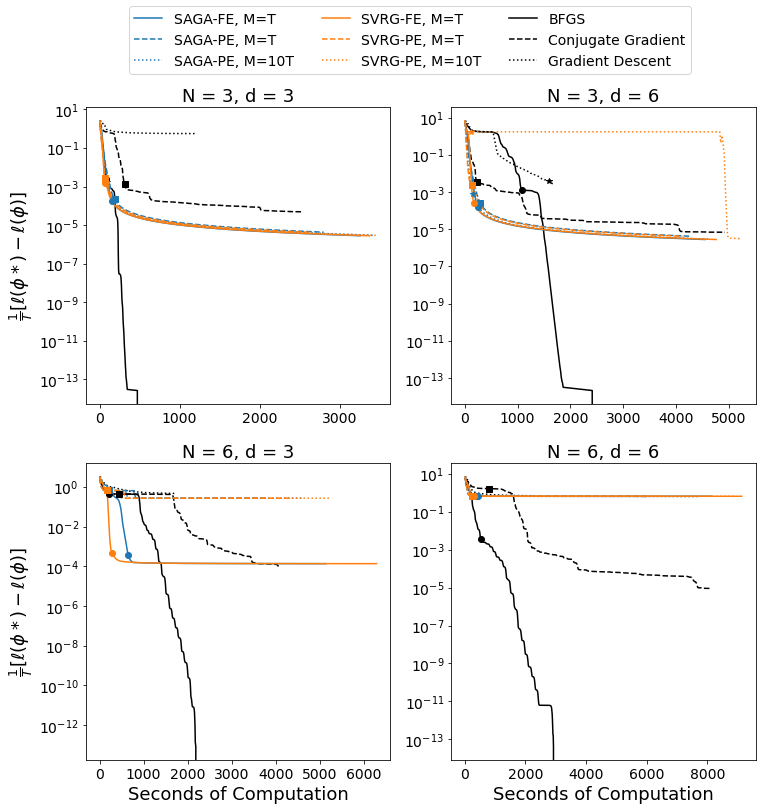

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


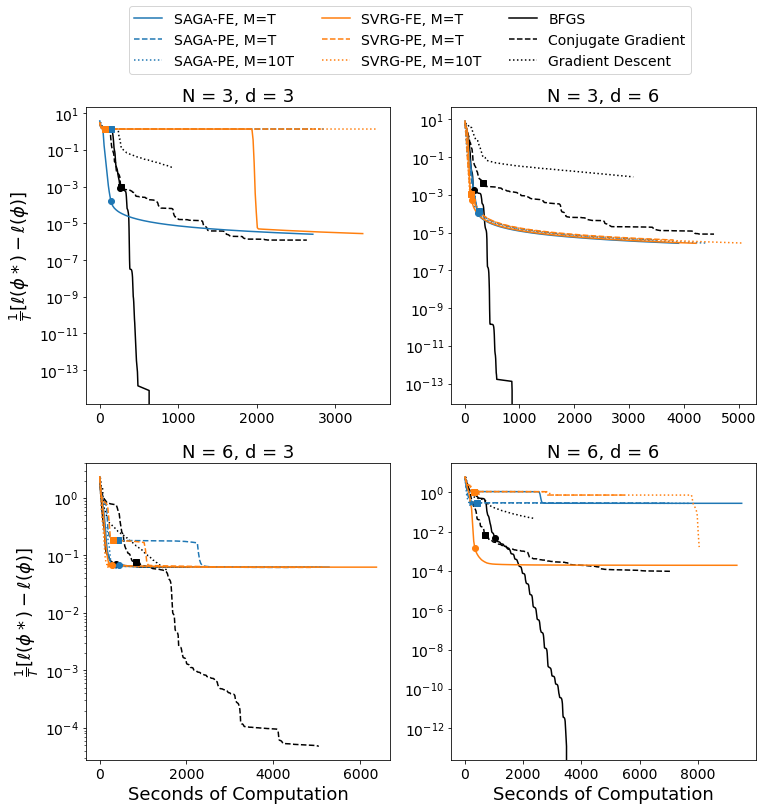

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


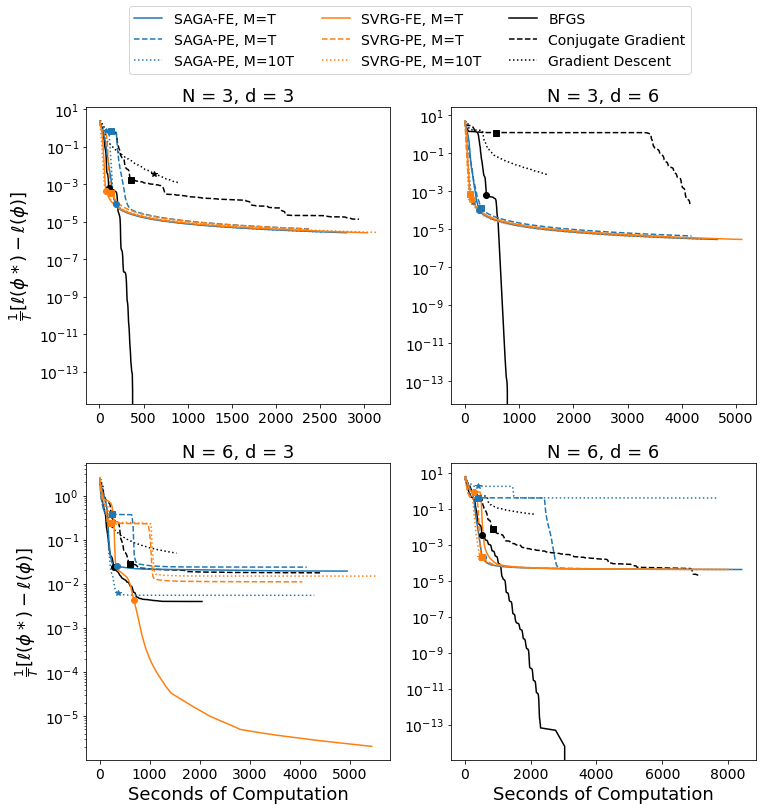

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


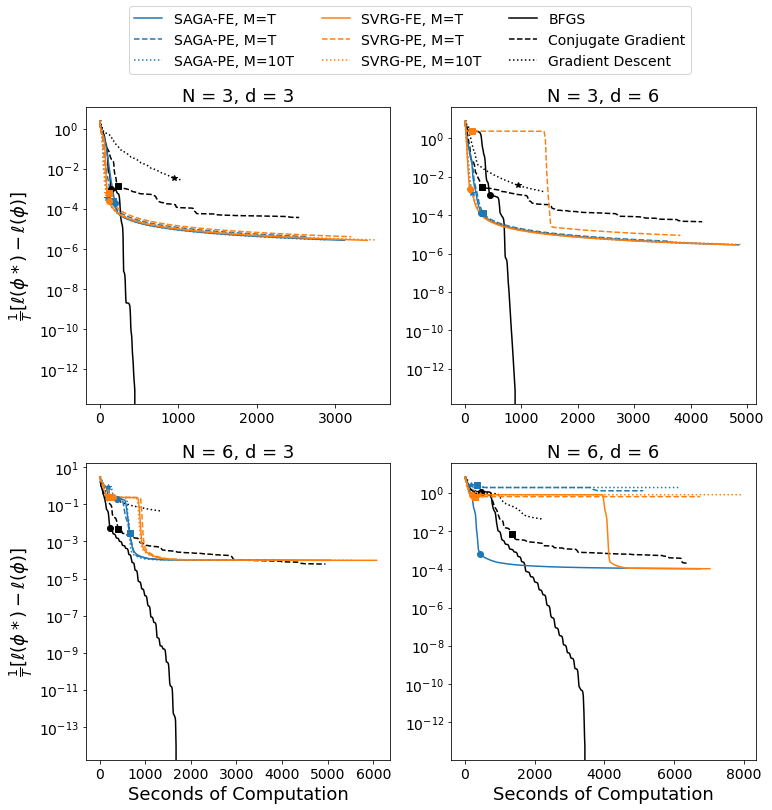

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


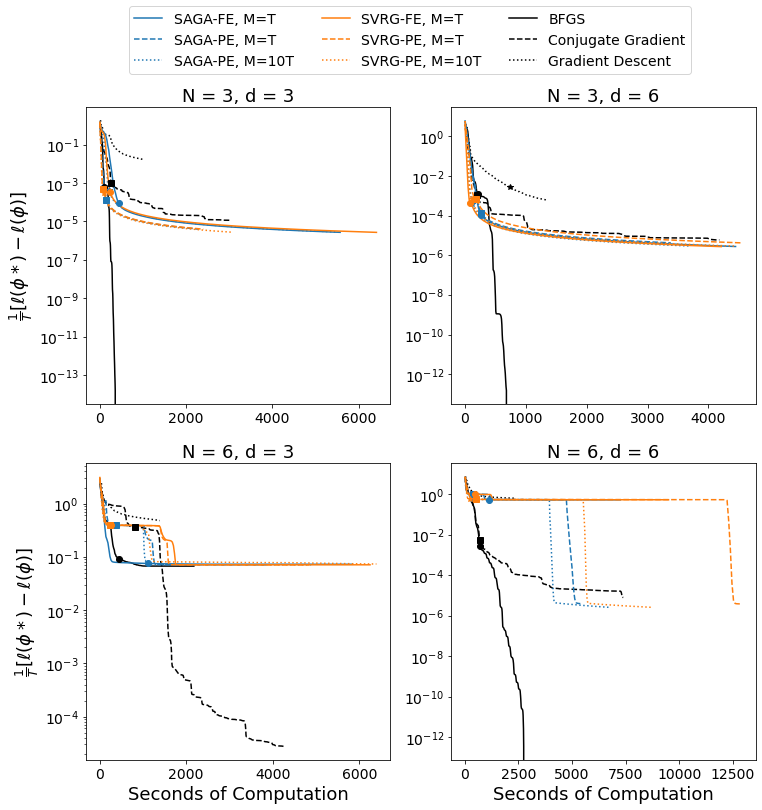

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


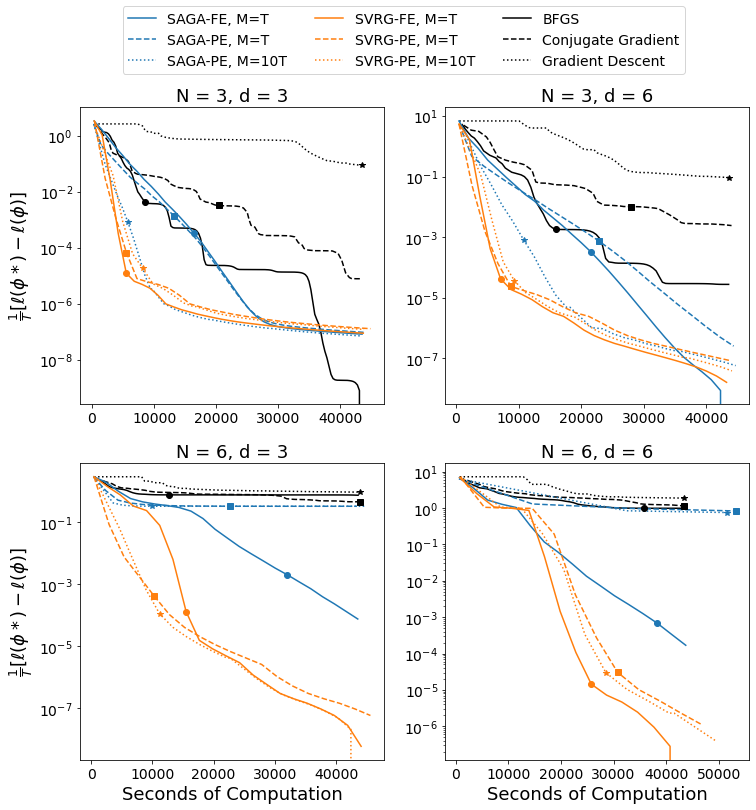

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


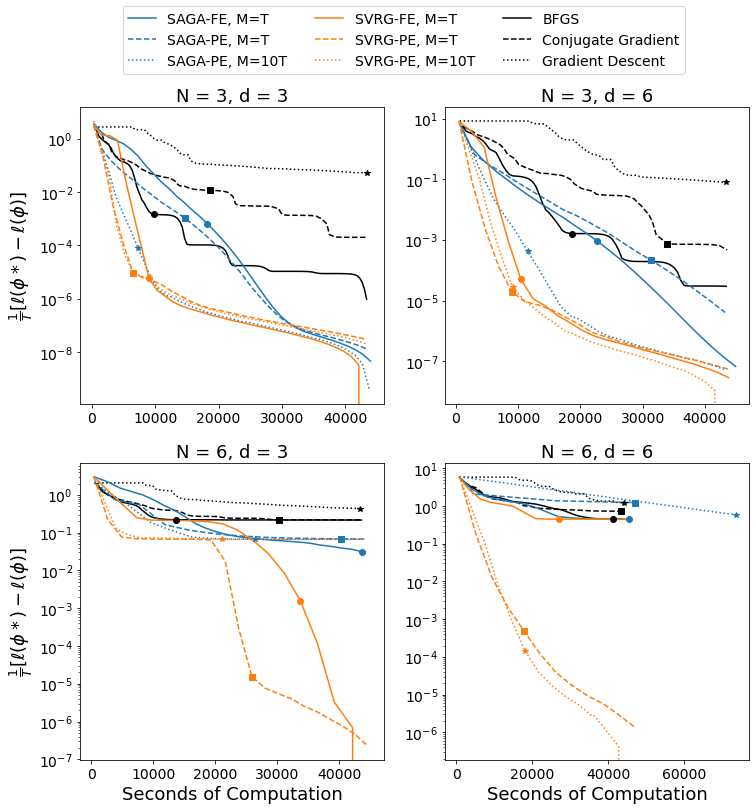

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


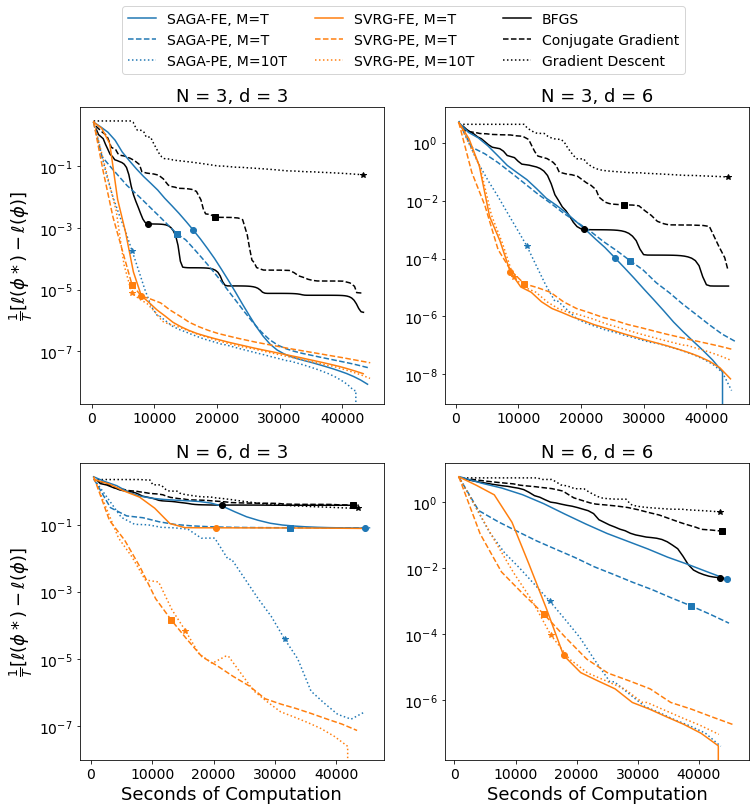

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


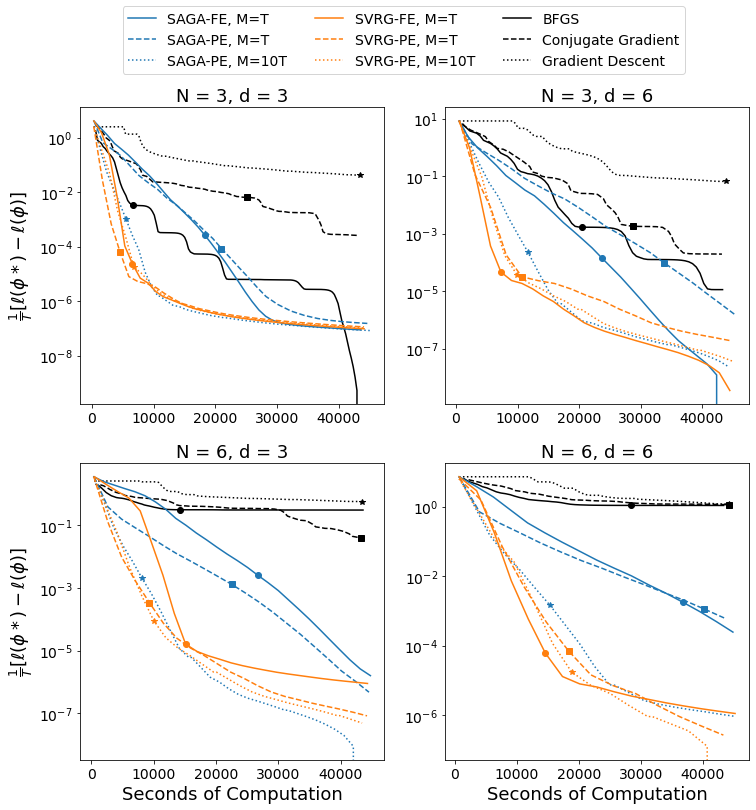

[3, 1] 3
[6, 1] 3
[3, 1] 6
[6, 1] 6


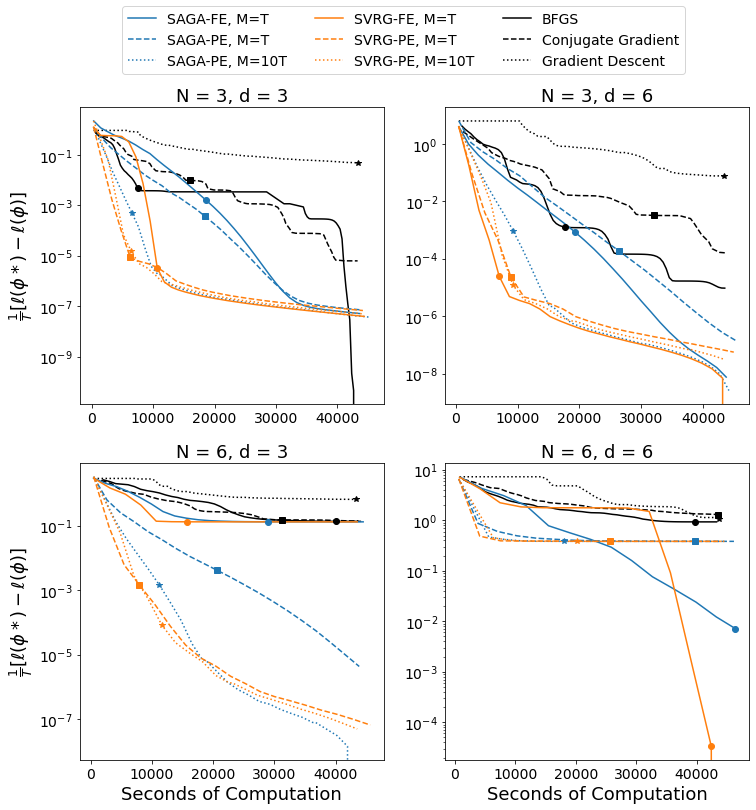

In [17]:
# get plotting parameters

cmap = cm.get_cmap('tab10')

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

pointstyles = {("BFGS",0.0):("black","o"),
               ("CG",0.0)  :("black","s"),
               ("GD",0.0)  :("black","*"),
               ("SVRG",0.0):(cmap(1),"o"),
               ("SVRG",0.5):(cmap(1),"s"),
               ("SVRG",1.0):(cmap(1),"*"),
               ("SAGA",0.0):(cmap(0),"o"),
               ("SAGA",0.5):(cmap(0),"s"),
               ("SAGA",1.0):(cmap(0),"*")}

labels = {("SAGA",0.0): "SAGA-FE, M=T",
          ("SAGA",0.5): "SAGA-PE, M=T",
          ("SAGA",1.0): "SAGA-PE, M=10T",
          ("SVRG",0.0): "SVRG-FE, M=T",
          ("SVRG",0.5): "SVRG-PE, M=T",
          ("SVRG",1.0): "SVRG-PE, M=10T",
          ("BFGS",0.0): "BFGS",
          ("CG",0.0)  : "Conjugate Gradient",
          ("GD",0.0)  : "Gradient Descent"}

legend_elements = []

for key in labels:
    legend_elements.append(Line2D([0], [0], 
                                  color=linestyles[key][0], 
                                  linestyle=linestyles[key][1], 
                                  label=labels[key]))

x_time = True
xlims = None
ylims = None
max_epoch = 500

for T in [1000,100000]:
    for dataset in range(5):

        fig, axs = plt.subplots(2,2,figsize = (12,12))

        for xind,d in enumerate([3,6]):
            for yind,K in enumerate([[3,1],[6,1]]):

                print(K,d)

                optims,lls,epochs_to_converge,times_to_converge = load_optims(T,K,d,dataset)
                ll_star = get_ll_star(optims)

                for method in methods:

                    if method == 'control':
                        continue

                    for partial_E in [0,0.5,1]:

                        if (method,partial_E) in optims:

                            optim = optims[(method,partial_E)]
                            eind = min(np.where(np.array(optim.epoch_trace) >= max_epoch)[0],
                                       default=len(optim.grad_norm_trace))

                            if x_time:
                                axs[yind,xind].plot(optim.time_trace[:eind],
                                                    ll_star-optim.log_like_trace[:eind],
                                                    color=linestyles[(method,partial_E)][0],
                                                    linestyle=linestyles[(method,partial_E)][1])
                            else:
                                axs[yind,xind].plot(optim.epoch_trace[:eind],
                                                    ll_star-optim.log_like_trace[:eind],
                                                    color=linestyles[(method,partial_E)][0],
                                                    linestyle=linestyles[(method,partial_E)][1])

                # add points
                max_x = 0
                min_y = 1e-4

                for method in methods:
                    if method == 'control':
                        continue
                    for partial_E in [0,0.5,1]:
                        if (method,partial_E) in optims:
                            optim = optims[(method,partial_E)]
                            converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                               default=len(optim.grad_norm_trace)-1)
                            eind = min(np.where(np.array(optim.epoch_trace) >= max_epoch)[0],
                                       default=len(optim.grad_norm_trace))

                            if converge_ind > eind:
                                continue

                            if method != 'GD':
                                if optim.epoch_trace[converge_ind] > max_x:
                                    max_x = optim.epoch_trace[converge_ind]
                                if ll_star-optim.log_like_trace[converge_ind] < min_y:
                                    min_y = ll_star-optim.log_like_trace[converge_ind]

                            if x_time:
                                axs[yind,xind].plot(optim.time_trace[converge_ind],
                                                    ll_star-optim.log_like_trace[converge_ind],
                                                    color = pointstyles[(method,partial_E)][0],
                                                    marker = pointstyles[(method,partial_E)][1])
                            else:
                                axs[yind,xind].plot(optim.epoch_trace[converge_ind],
                                                    ll_star-optim.log_like_trace[converge_ind],
                                                    color = pointstyles[(method,partial_E)][0],
                                                    marker = pointstyles[(method,partial_E)][1])

                if not xlims is None:
                    axs[yind,xind].set_xlim(xlims)
                if not ylims is None:
                    axs[yind,xind].set_ylim(ylims)

                axs[yind,xind].set_yscale("log")
                axs[yind,xind].set_title("N = %d, d = %d" % (K[0],d),fontsize=18)

                if xind == 0:
                    axs[yind,xind].set_ylabel(r"$\frac{1}{T} \left[\ell(\phi*) - \ell(\phi)\right]$",fontsize=18)

                if yind == 1:
                    if x_time: 
                        axs[yind,xind].set_xlabel("Seconds of Computation",fontsize=18)
                    else:
                        axs[yind,xind].set_xlabel("Epoch",fontsize=18)

                if not x_time:
                    axs[yind,xind].set_xlim([0,max(150,2*max_x)])    
                
                axs[yind,xind].set_ylim([1e-8,1e1])
                
                #axs[yind,xind].set_xlim([0,10])    
                #axs[yind,xind].set_ylim([1e-3,1e1])

                axs[yind,xind].tick_params(axis='both', which='major', labelsize=14)
                axs[yind,xind].tick_params(axis='both', which='minor', labelsize=14)


        fig.legend(handles=legend_elements,
                   loc='upper center', 
                   fontsize=14,
                   bbox_to_anchor=(0.5, 1.005),
                   ncol=3)
    
        if x_time:
            fig.savefig(plot_folder + "/log-like_v_time_T-%d-%03d.png"%(T,dataset),
                        dpi=500,bbox_inches='tight')
        else:
            fig.savefig(plot_folder + "/log-like_v_epoch_T-%d-%03d.png"%(T,dataset),
                        dpi=500,bbox_inches='tight')

        plt.show()